#ARIMA model

##Data preprocessing

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from google.colab import drive
from scipy.stats import normaltest
import statsmodels.api as sm

Close prices

[*********************100%***********************]  1 of 1 completed


ADF Statistic: 3.0132771124344058
P-value: 1.0
Normal test Statistic: 1024.215
P-value: 0.000


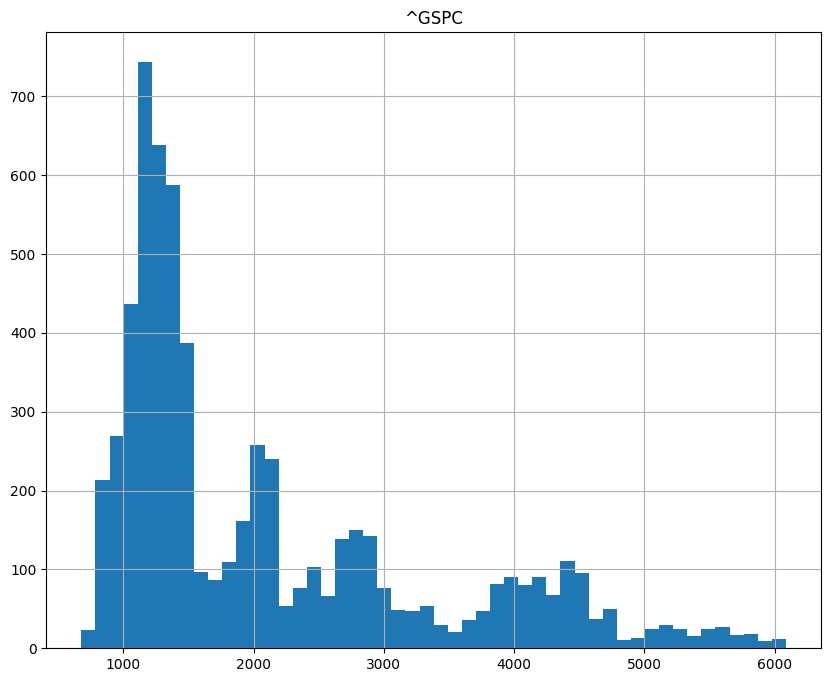

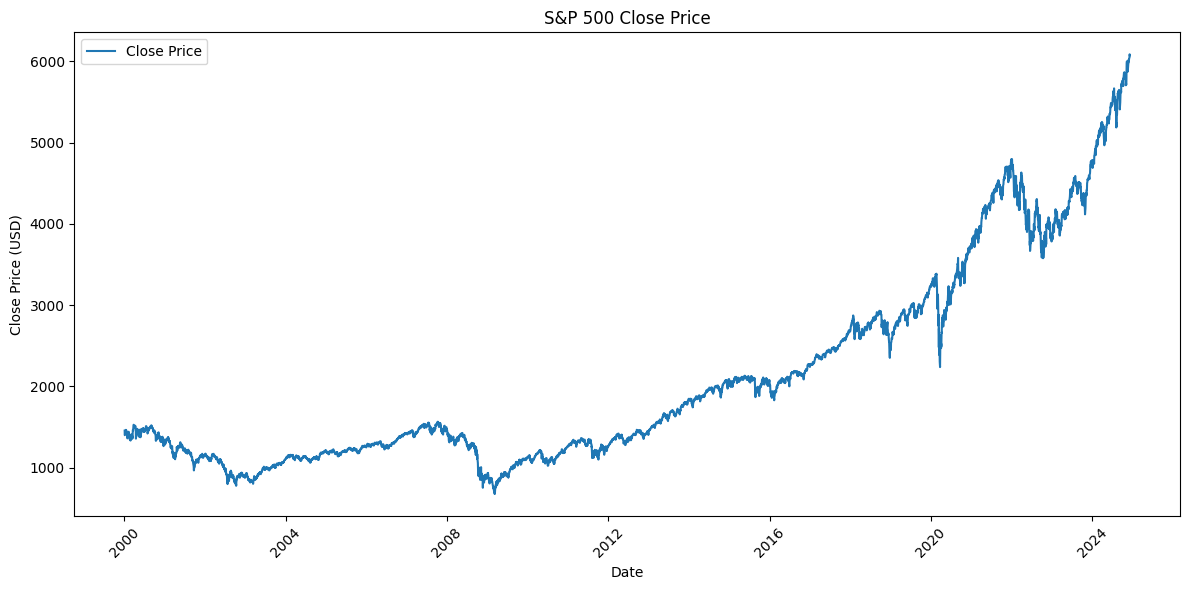

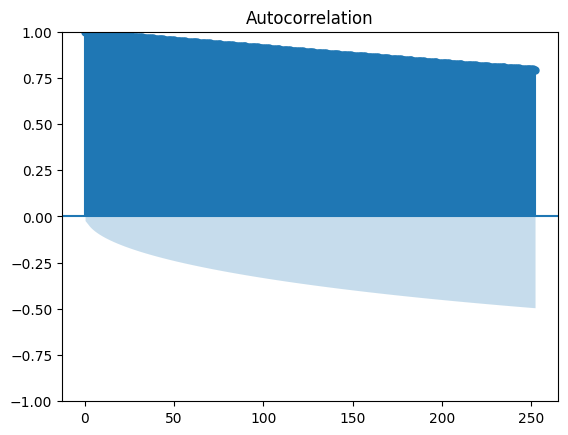

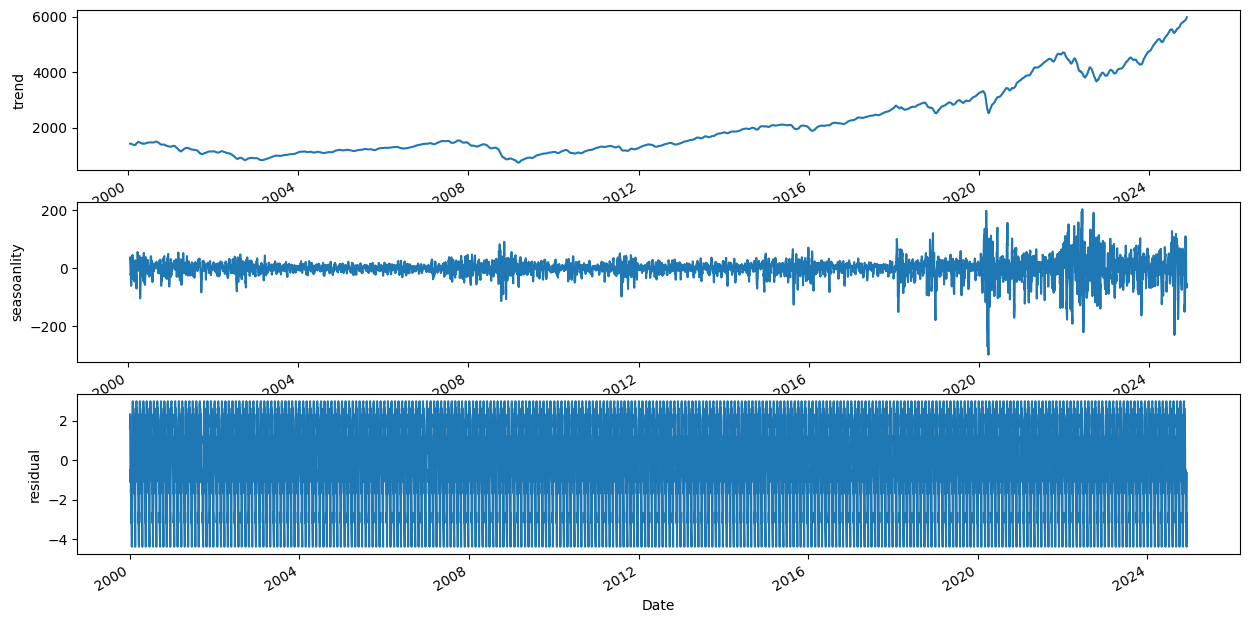

In [ ]:
#import financial time series
ticker = "^GSPC"
start_date = "2000-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")
sp500_data = yf.download(ticker, start = start_date, end = end_date, interval="1d")
sp500_data.index = sp500_data.index.tz_localize(None)


#test stationarity with the Augmented Dickey-Fuller (ADF) test
result = adfuller(sp500_data['Close'])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}") # If the p-value is less than 0.05, the series is likely stationary


#test normality with Normality test
stat, p = normaltest(sp500_data['Close'])
print(f"Normal test Statistic: {stat[0]:.3f}")
print(f"P-value: {p[0]:.3f}") # If the p-value is more than 0.05, the series is normally distributed


#visualise
sp500_data['Close'].hist(bins=50, figsize=(10, 8))
plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(data=sp500_data['Close'])
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend( labels=["Close Price"])
plt.show()


#plot autocorrelation
plot_acf(sp500_data['Close'], lags=252)
plt.show()


#decompose time series
res = seasonal_decompose(sp500_data['Close'], model = "additive",period = 21)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

Log returns

Mounted at /content/gdrive
ADF Statistic: -19.035737703521313
P-value: 0.0
Normal test Statistic: 1024.215
P-value: 0.000


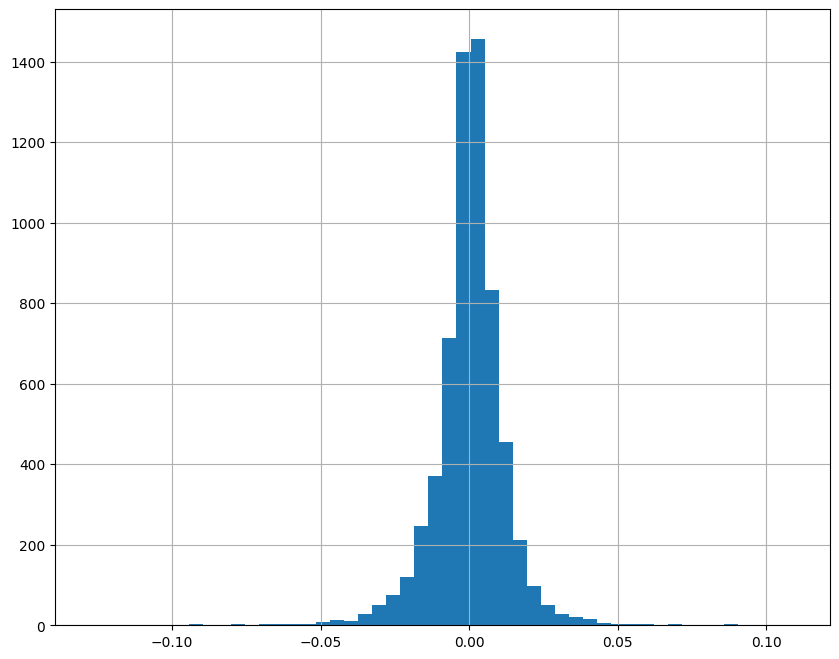

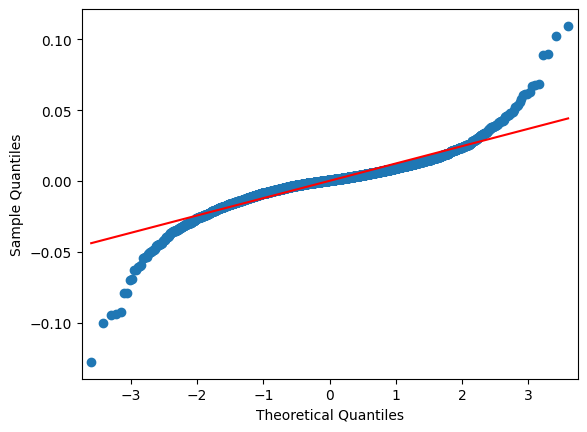

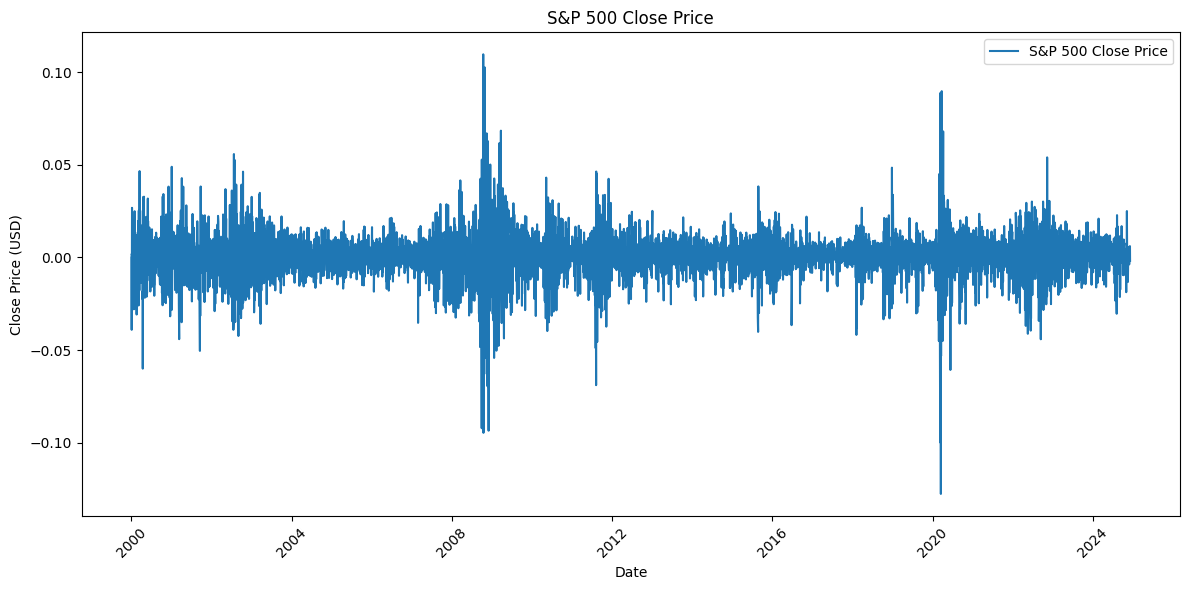

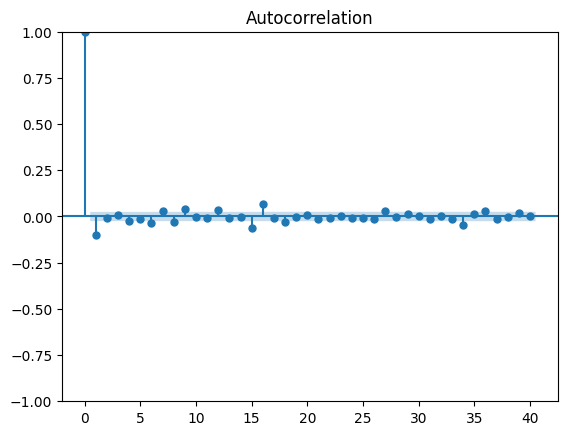

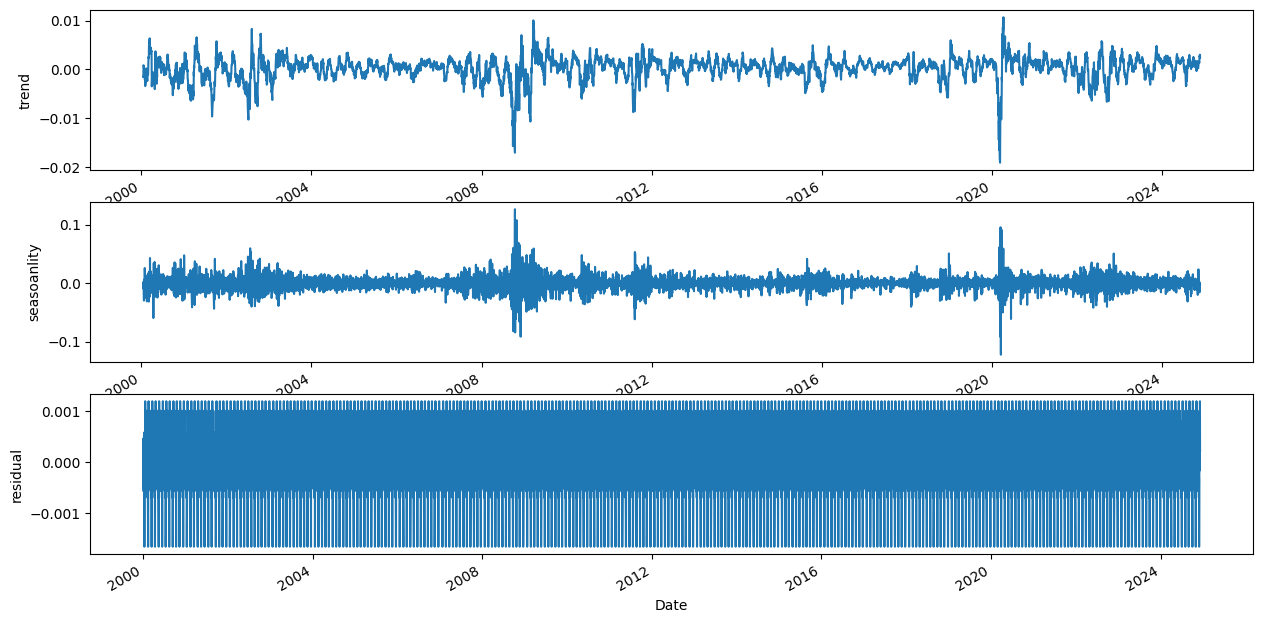

In [ ]:
#compute log returns
sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
#sp500_data.dropna(inplace = True)
sp500_data.fillna(0, inplace=True)


#save time series
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/sp500_data.csv'
sp500_data.to_csv(file_path, index=True)


#test stationarity with the Augmented Dickey-Fuller (ADF) test
result = adfuller(sp500_data['Log Return'])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}") # If the p-value is less than 0.05, the series is likely stationary


#test normality with Normality test
stat, p = normaltest(sp500_data['Close'])
print(f"Normal test Statistic: {stat[0]:.3f}")
print(f"P-value: {p[0]:.3f}") # If the p-value is more than 0.05, the series is normally distributed


sp500_data['Log Return'].hist(bins=50, figsize=(10, 8))
plt.show()

sm.qqplot(sp500_data['Log Return'], line='s')
plt.show()


#visualise
plt.figure(figsize=(12, 6))
sns.lineplot(x=sp500_data.index, y=sp500_data['Log Return'], label="S&P 500 Close Price")
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.show()


# Plot the ACF
plot_acf(sp500_data['Log Return'], lags=40)  # You can adjust the number of lags
plt.show()


#decompose time series
res = seasonal_decompose(sp500_data['Log Return'], model = "additive",period = 21)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

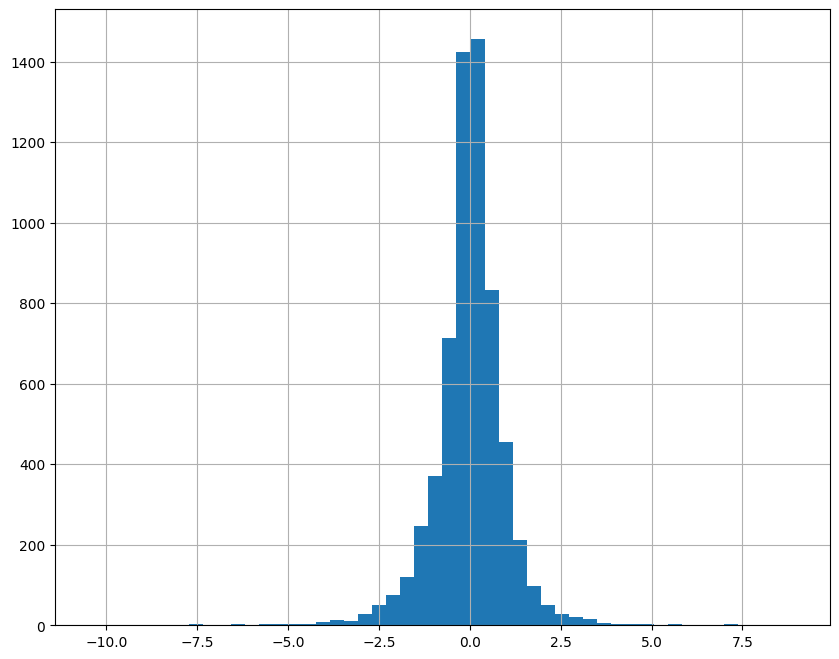

Normal test Statistic: 1270.513
P-value: 0.000


In [ ]:
# Normalize by dividing by standard deviation
normalized_returns = (sp500_data['Log Return'] -sp500_data['Log Return'].mean()) / sp500_data['Log Return'].std()
normalized_returns.hist(bins=50, figsize=(10, 8))
plt.show()

#test normality
stat, p = normaltest(normalized_returns)
print(f"Normal test Statistic: {stat:.3f}")
print(f"P-value: {p:.3f}")

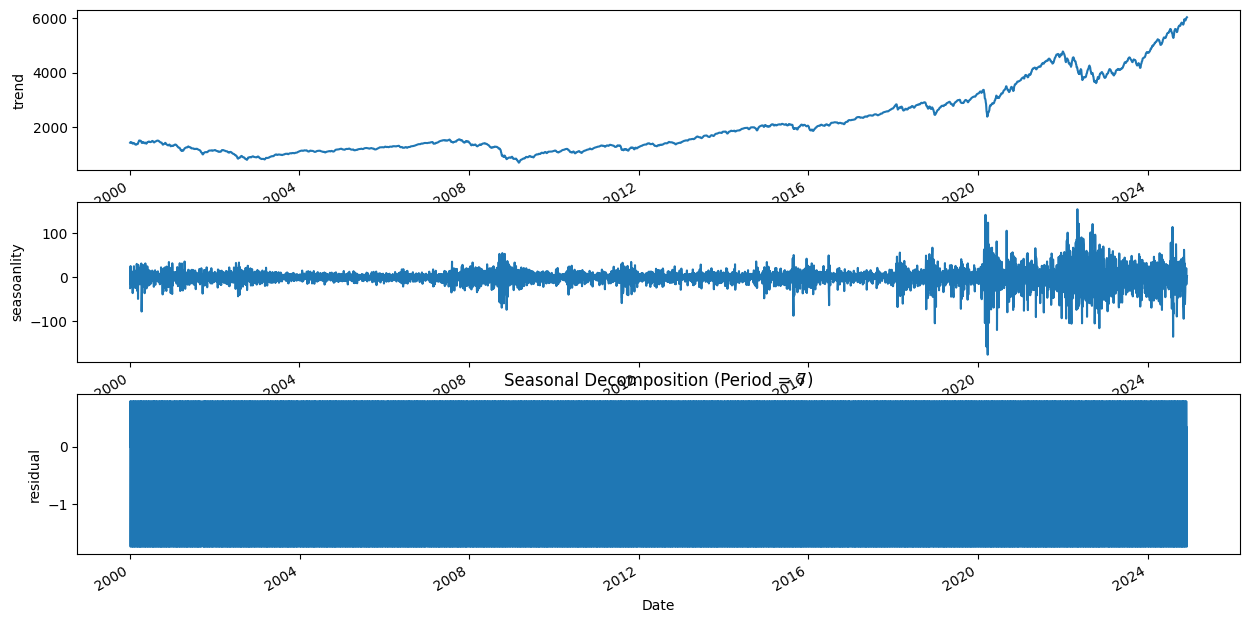

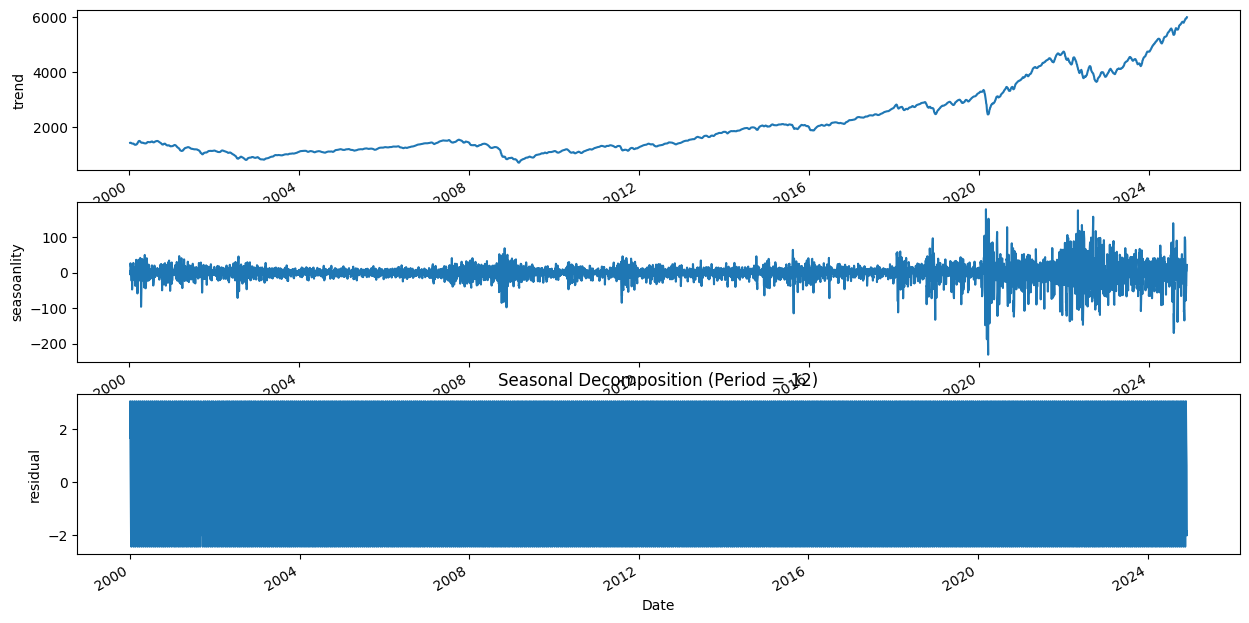

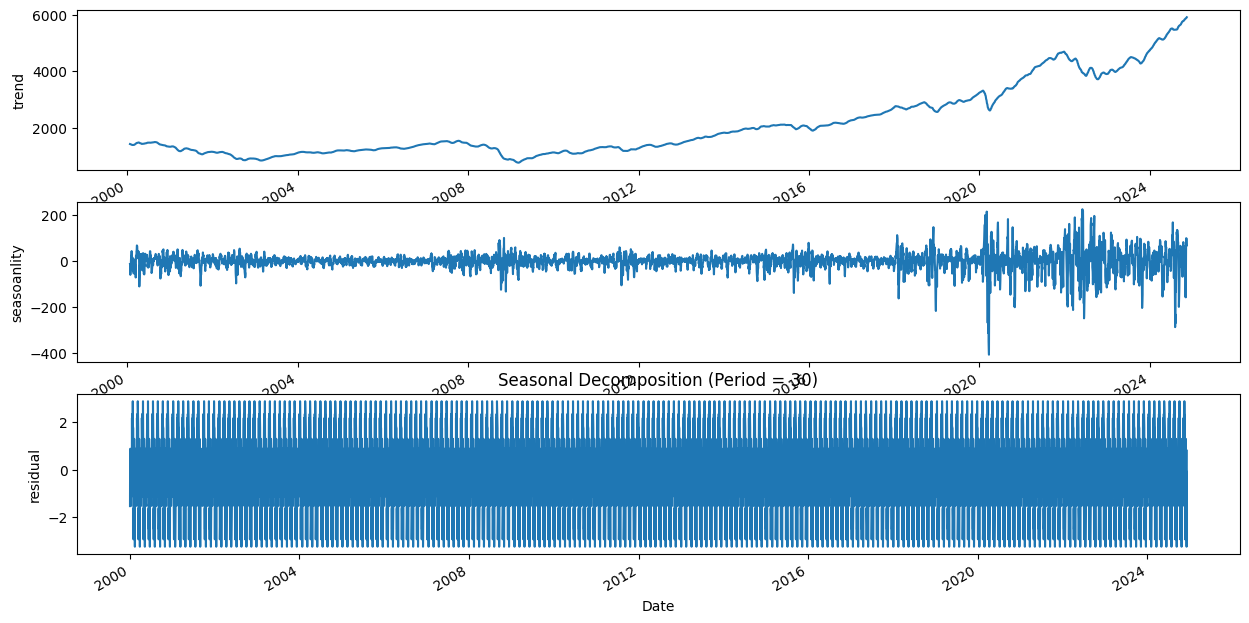

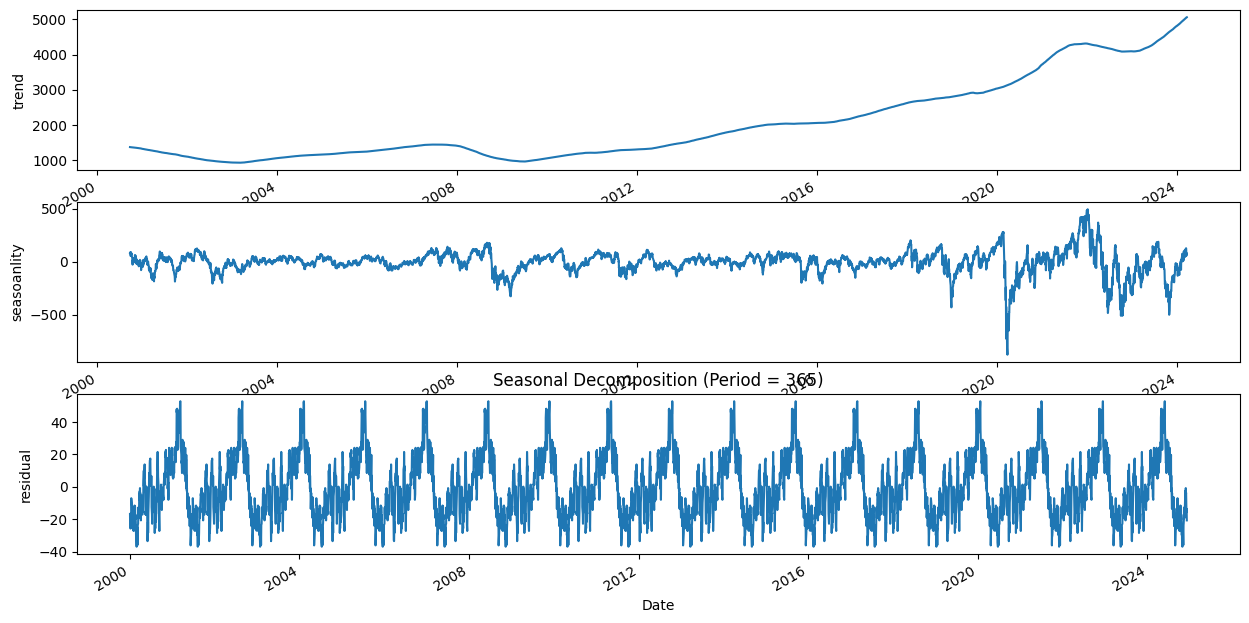

In [ ]:
periods = [7, 12, 30, 365]  # Example: weekly, monthly, 30-day, yearly
for period in periods:
  res = seasonal_decompose(sp500_data['Close'], model = "additive",period = period)
  fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
  res.trend.plot(ax=ax1,ylabel = "trend")
  res.resid.plot(ax=ax2,ylabel = "seasoanlity")
  res.seasonal.plot(ax=ax3,ylabel = "residual")
  plt.title(f"Seasonal Decomposition (Period = {period})")
  plt.show()

##ARIMA model
The ARIMA model has three key parameters:

* p: The order of the autoregressive (AR) term.
* d: The degree of differencing to make the series stationary.
* q: The order of the moving average (MA) term.

In [ ]:
!pip install arm-mango


In [ ]:
#libraries
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler #to perform Bayesian optimization
from mango.tuner import Tuner
from google.colab import drive
from joblib import Parallel, delayed, dump, load
import time

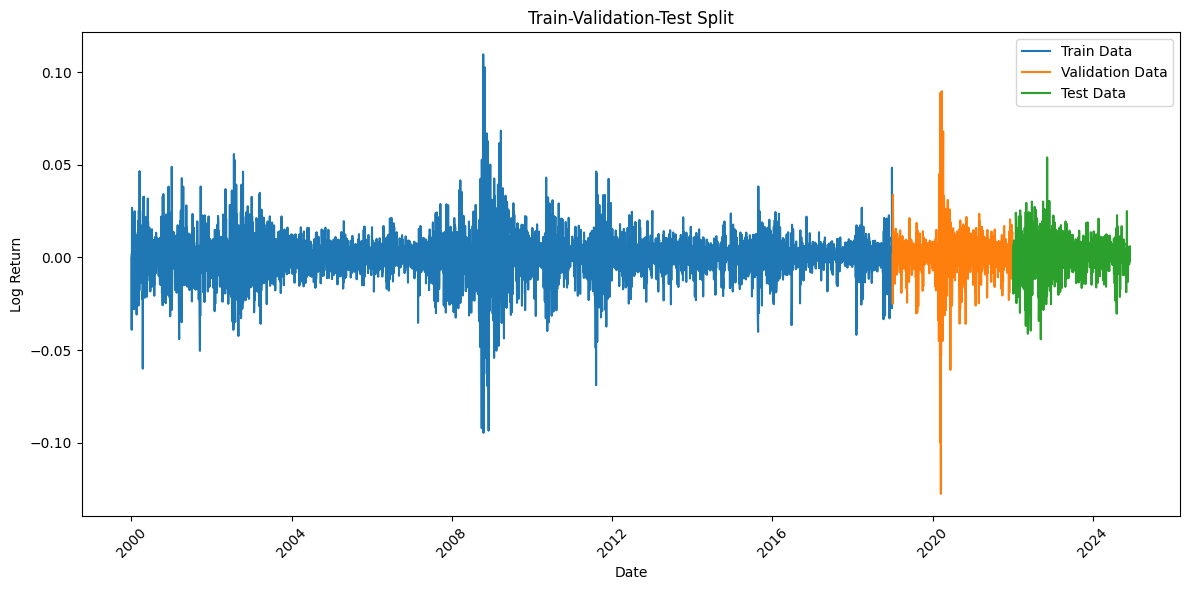

In [ ]:
#train / validation / test split
train_data = sp500_data['Log Return'].loc[: '2018']
val_data = sp500_data['Log Return'].loc['2019': '2021']
test_data = sp500_data['Log Return'].loc['2022':]


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=train_data.values, label="Train Data")
sns.lineplot(x=val_data.index, y=val_data.values, label="Validation Data")
sns.lineplot(x=test_data.index, y=test_data.values, label="Test Data")
plt.title('Train-Validation-Test Split')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

###Find the best hyperparameter using Bayesian Optimization

In [ ]:
#define objective function
def arima_objective_function (args_list):
  global train_data, test_data
  params_evaluated = [] # list that will hold the parameters tested
  results = [] # thi will hold the MSE values for each parameter set.

  for params in args_list:
      try:
          p,d,q = params['p'],params['d'], params['q']
          trend = params['trend']
          model = ARIMA(train_data, order=(p,d,q), trend = trend).fit() #train ARIMA model with the subset of hyperparameters
          predictions = model.forecast(steps=len(test_data)) #get forecast
          mse = mean_squared_error(test_data, predictions) #compute mse
          params_evaluated.append(params)
          results.append(mse)
      except:
          #print(f"Exception raised for {params}")
          #pass
          params_evaluated.append(params)
          results.append(1e5)  #if an error occurs the function appends a very large MSE (1e5) to results, which serves as a penalty for that parameter combination.

      #print(params_evaluated, mse)
  return params_evaluated, results


#define the search space
param_space = dict(p= range(6, 30),  #use of range to ensure integers
                   d=[0],
                   q =range(6, 30),
                   trend = ['n']
                  )


#run optimization
conf_Dict = {'num_iteration': 50 , 'initial_random' : 5}  #configuration dictionary , number of iteration
tuner = Tuner(param_space, arima_objective_function, conf_Dict) # Initialize Tuner
results = tuner.minimize()  #Bayesian optimization to minimize the objective function
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, train_data, val_data):
      self.conf_dict = configuration_params  # parameters to configure the Tuner
      self.njobs = njobs
      self.train_data = train_data
      self.val_data = val_data
      self.space = dict(p= range(6, 30), # Definition of the search space of the algorithm
                        d=[0],
                        q =range(6, 30),  #use of range to ensure integers
                        trend = ['t']
                        )


  #This is the loss function that mango optimizes
  def arima_objetive_function(self, **params):
    params_evaluated = [] # list that will hold the parameters tested
    results = [] # thi will hold the MSE values for each parameter set.

    try:
      p,d,q = params['p'],params['d'], params['q']
      trend = params['trend']
      model = ARIMA(self.train_data, order=(p,d,q), trend = trend).fit() #train ARIMA model with the subset of hyperparameters
      predictions = model.forecast(steps=len(self.val_data)) #get forecast
      mse = mean_squared_error(self.val_data, predictions) #compute mse
      params_evaluated.append(params)
      results.append(mse)
    except:
      #print(f"Exception raised for {params}")
      #pass
      params_evaluated.append(params)
      results.append(1e5)  #if an error occurs the function appends a very large MSE (1e5) to results, which serves as a penalty for that parameter combination.
    return results


  def _objective2(self, params_batch): #to perform bayesian optimization in parallel
      global parameters
      results_batch = Parallel(self.njobs, backend="multiprocessing")(delayed(self.arima_objetive_function)(**params) for params in params_batch)
      rmse = [result for result in results_batch]
      return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


 # Parallel Bayesian optimization
config_params = {'num_iteration': 50, 'initial_random': 10}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, train_data=train_data, val_data=val_data)
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')

# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimisation in parallel takes 90.03256151676177 minutes.
best parameters: {'d': 0, 'p': 8, 'q': 13, 'trend': 't'}
best accuracy: 0.0002022716167783855


###ARIMA Predictions

MSE: 0.00012208501760440347
RMSE 0.01104920891305814
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


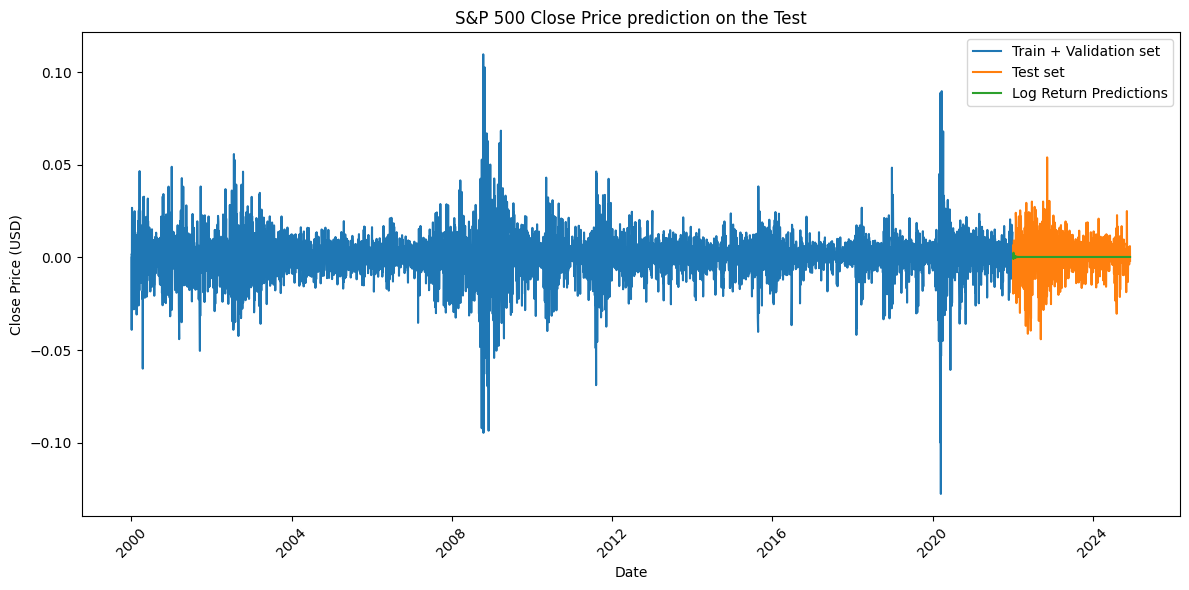

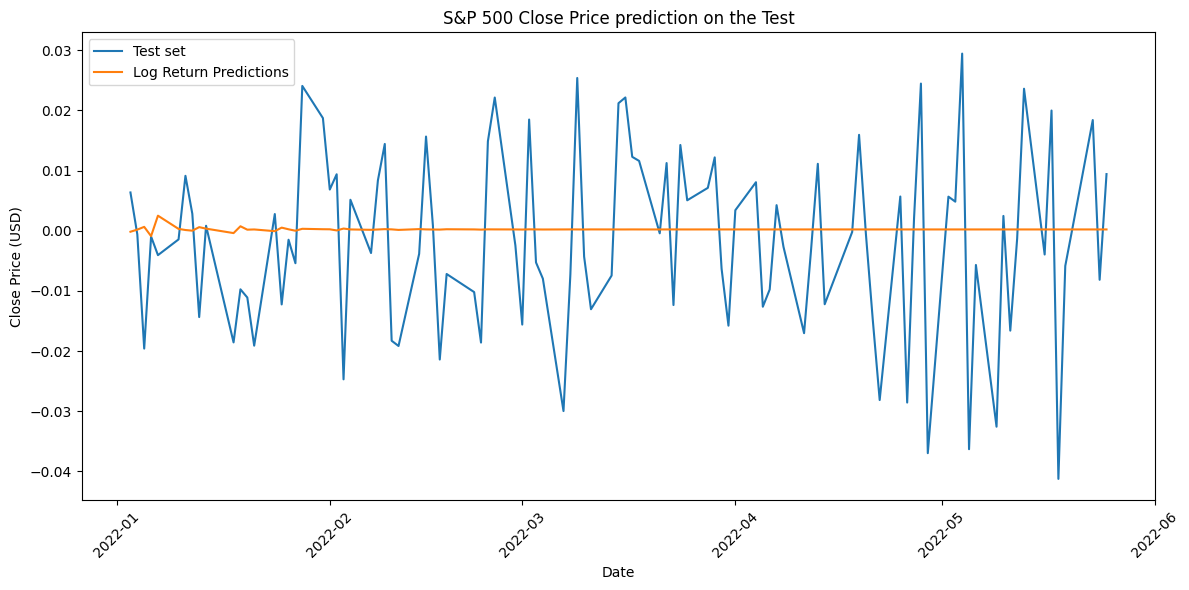

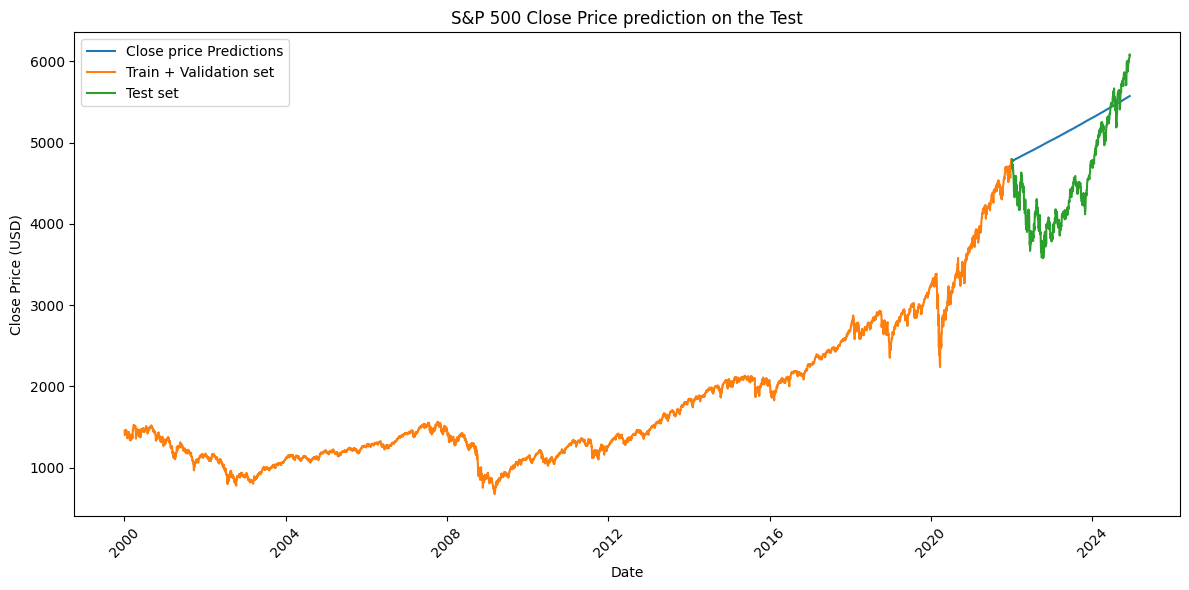

In [ ]:
best_params = {'d': 0, 'p': 8, 'q': 13, 'trend': 'c'} #c assume a non zero mean
train_val_data = pd.concat([train_data, val_data])  #combine train and validation data
model = ARIMA(train_val_data, order=(best_params['p'], best_params['d'], best_params['q']), trend=best_params['trend']).fit()  #train model
forecast = model.forecast(steps=len(test_data)) ##predict
forecast.index = sp500_data.index[len(train_val_data):]
test_residuals = pd.Series((test_data.values-forecast.values))
test_residuals.index = test_data.index


#compute MSE
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE', rmse)


#save arima predictions
drive.mount("/content/gdrive")
df_arima_predictions = pd.Series(forecast)
df_arima_predictions.index = sp500_data.index[len(train_val_data):]
file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/arima_predictions.csv'
df_arima_predictions.to_csv(file_path, index=True)


#visualize
#log predictions
plt.figure(figsize=(12, 6))
sns.lineplot(data = train_val_data, label="Train + Validation set")
sns.lineplot(data = test_data, label="Test set")
sns.lineplot(data = forecast, label="Log Return Predictions")
plt.title('S&P 500 Close Price prediction on the Test')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#close up
plt.figure(figsize=(12, 6))
sns.lineplot(data = test_data[:100], label="Test set")
sns.lineplot(data = forecast[:100], label="Log Return Predictions")
plt.title('S&P 500 Close Price prediction on the Test')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#cllose price predictions
forecast = pd.Series(forecast)
forecast.index = sp500_data.index[len(train_val_data):]
lista = pd.concat([train_val_data, forecast])
pd.set_option('display.float_format', '{:.6f}'.format)
initial_price = sp500_data['Close']['^GSPC'].iloc[0]
predicted_close_price = initial_price * np.exp(lista.cumsum())
predicted_close_price

plt.figure(figsize=(12, 6))
sns.lineplot(data = predicted_close_price[len(train_val_data):], label="Close price Predictions")
sns.lineplot(data = sp500_data['Close']['^GSPC'][:len(train_val_data)], label="Train + Validation set")
sns.lineplot(x=sp500_data[len(train_val_data):].index, y=sp500_data['Close'][len(train_val_data):].squeeze(), label="Test set")
plt.title('S&P 500 Close Price prediction on the Test')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


arima model: (8, 0, 13) c
MSE: 0.00014961930860154214
RMSE: 0.012231897179159991
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


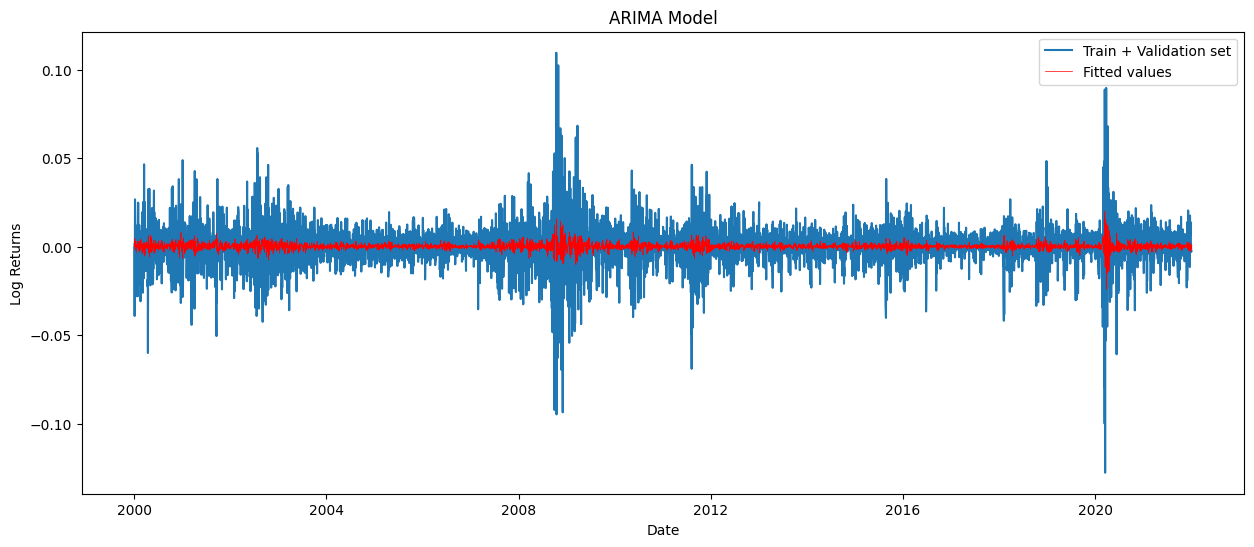

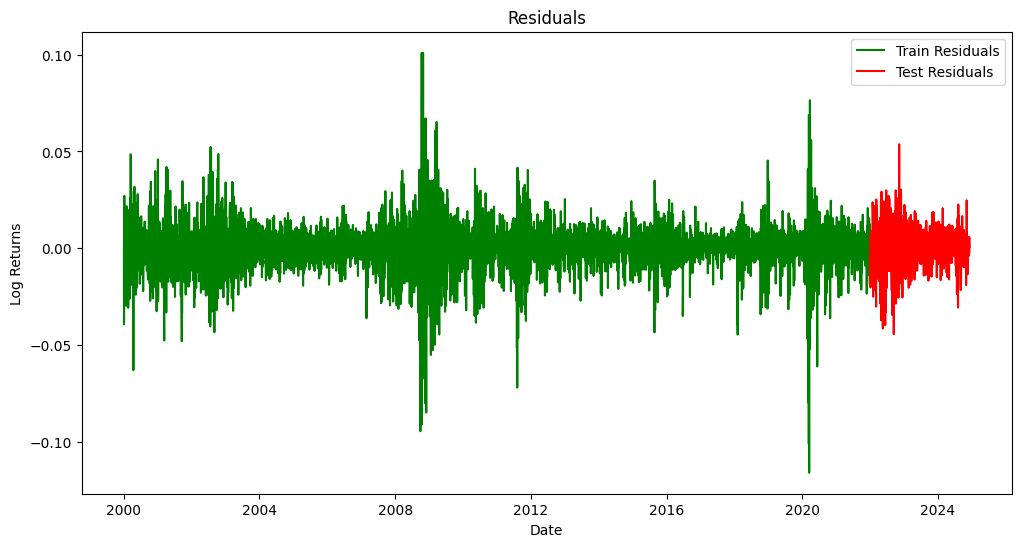

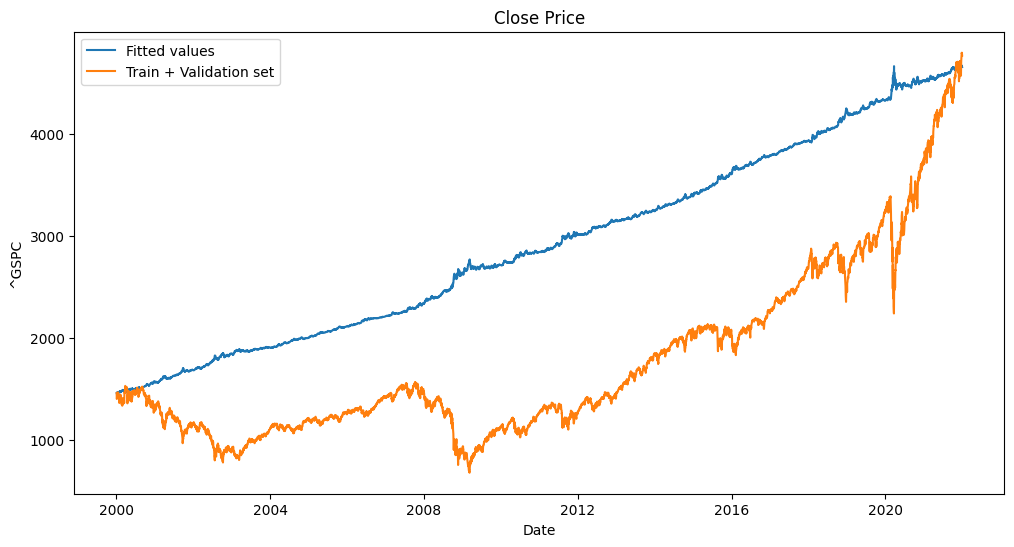

In [ ]:
def plot_arima(data, order , trend):
  print('arima model:', order, trend)
  model = ARIMA(data, order=order, trend = trend)
  results = model.fit()
  train_residuals = results.resid  #residuals
  mse = mean_squared_error(data, results.fittedvalues)
  rmse = np.sqrt(mse)
  print('MSE:', mse)
  print('RMSE:', rmse)


  #save residuals on google
  drive.mount("/content/gdrive")
  df_residuals = pd.concat([train_residuals, test_residuals]).rename('Residuals')
  df_residuals.index = sp500_data.index
  file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/residuals.csv'
  df_residuals.to_csv(file_path, index=True)


  #log return prediction on train + val set
  f = plt.figure()
  f.set_figwidth(15)
  f.set_figheight(6)
  plt.plot(data, label = "Train + Validation set")
  plt.plot(results.fittedvalues, color='red', label = "Fitted values", linewidth=0.5)
  plt.legend()
  plt.title('ARIMA Model')
  plt.xlabel('Date')
  plt.ylabel('Log Returns')
  plt.show()


  #residuals
  plt.figure(figsize=(12, 6))
  plt.plot(results.resid, color = 'green', label = "Train Residuals")
  plt.plot(test_residuals, color = 'red', label = "Test Residuals")
  plt.legend()
  plt.title('Residuals')
  plt.xlabel('Date')
  plt.ylabel('Log Returns')
  plt.show()

  #convert log returns back into close prices
  initial_price = sp500_data['Close']['^GSPC'].iloc[0]
  predicted_close_price = initial_price * np.exp(results.fittedvalues.cumsum())
  plt.figure(figsize=(12, 6))
  plt.title('ARIMA Model results using close prices')
  sns.lineplot(data=predicted_close_price, label="Fitted values")
  sns.lineplot(x=sp500_data[:len(train_val_data)].index, y=sp500_data['Close'][:len(train_val_data)].squeeze(), label="Train + Validation set")
  plt.title('Close Price')
  plt.xlabel('Date')
  plt.show



#train ARIMA on test set and compute residuals
#best_params = {'d': 0, 'p': 10, 'q': 12, 'trend': 't'} #best model found using Bayesian Optimization
best_params = {'d': 0, 'p': 8, 'q': 13, 'trend': 'c'}

order=(best_params['p'], best_params['d'], best_params['q'])
trend=best_params['trend']
plot_arima(train_val_data, order, trend)


In [ ]:
#save model
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/università\Tesi\models/arima_model.joblib'
dump(model, file_path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['/content/gdrive/MyDrive/università/Machine_learning/Project_code/models/arima_model.joblib']

In [ ]:
# Load the saved ARIMA model
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/università\Tesi\models/arima_model.joblib'
model = load(file_path)

##Naive estimator

MSE: 0.00012262366886485636
RMSE 0.011073557191113267


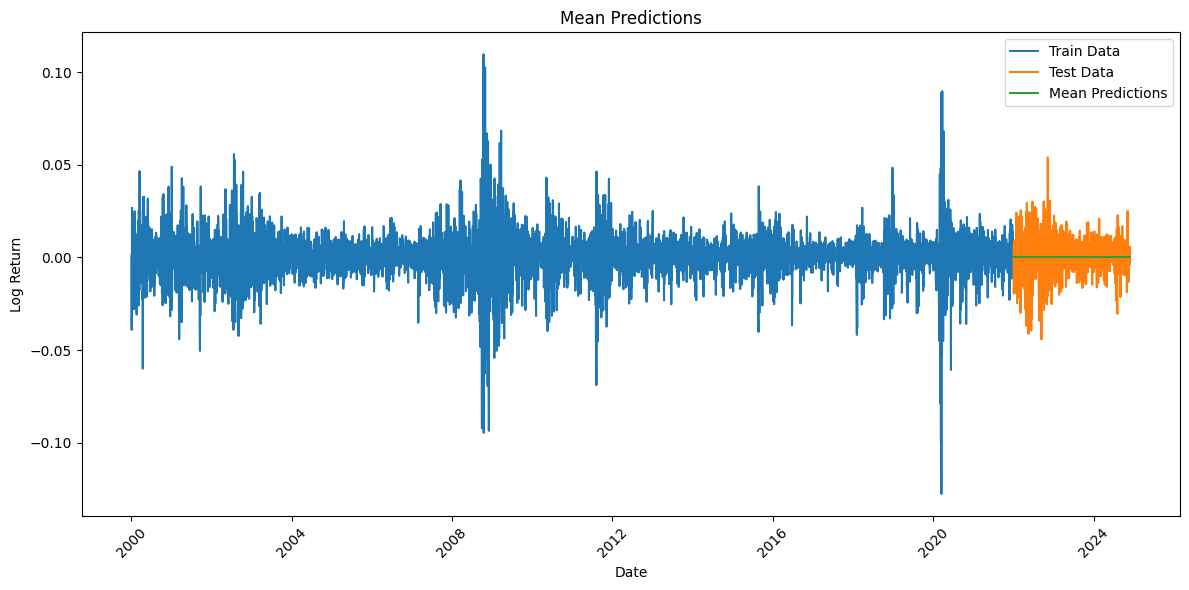

In [ ]:
class naive_estimator:
    def __init__(self):
        self.mean_value = None  # Initialize mean

    def fit(self, train_data):
        self.mean_value = np.mean(train_data)

    def predict(self, test_data):
        return np.full(len(test_data), self.mean_value)  # Creates array of mean values


mean_esitmator = naive_estimator()
mean_esitmator.fit(train_val_data)
predictions = mean_esitmator.predict(test_data)

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE', rmse)


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=train_val_data.values, label="Train Data")
sns.lineplot(x=test_data.index, y=test_data.values, label="Test Data")
sns.lineplot(x=test_data.index, y=predictions, label="Mean Predictions")
plt.title('Mean Predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

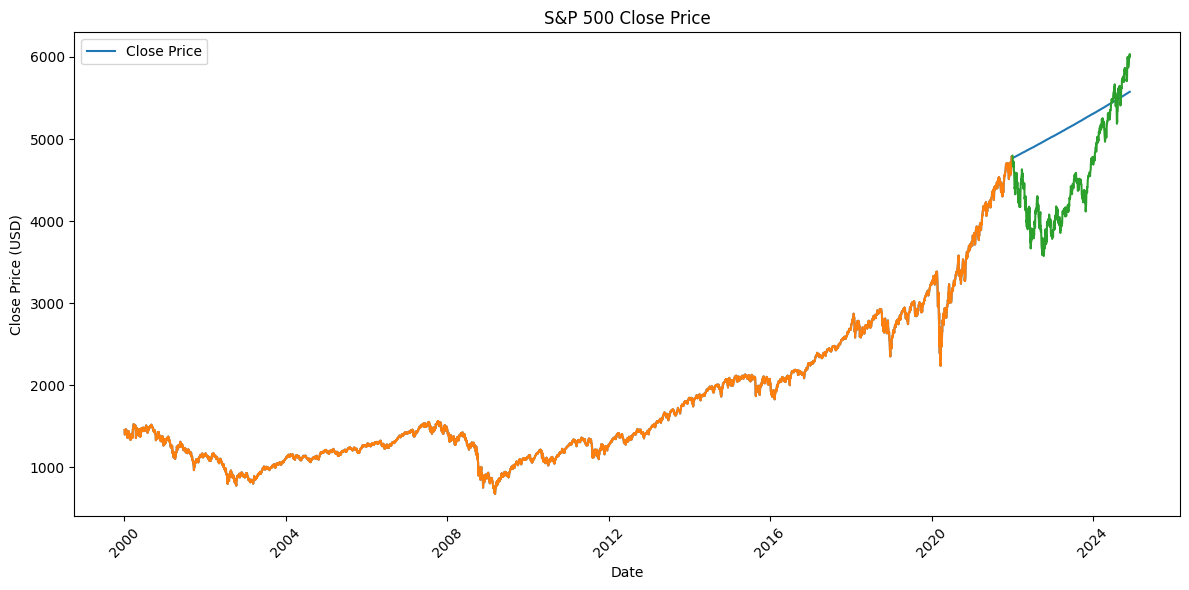

In [ ]:
lista = list(train_val_data)
lista.extend(predictions)
lista = pd.Series(lista)
pd.set_option('display.float_format', '{:.6f}'.format)

initial_price = sp500_data['Close']['^GSPC'].iloc[0]
predicted_close_price = initial_price * np.exp(lista.cumsum())
predicted_close_price


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=sp500_data.index, y=predicted_close_price, label="Predictions")
sns.lineplot(x=sp500_data[:len(train_val_data)].index, y=sp500_data['Close'][:len(train_val_data)].squeeze(), label="Train set")
sns.lineplot(x=sp500_data[len(train_val_data):].index, y=sp500_data['Close'][len(train_val_data):].squeeze(), label="Test set")
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend( labels=["Close Price"])
plt.show()


#SARIMA model

In [ ]:
!pip install skforecast


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')


# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings('once')


In [ ]:
from skforecast import datasets
from skforecast.datasets import fetch_dataset

data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.loc[:'1990-01-01 00:00:00']
data = data.asfreq('MS')
data = data['litters']

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


fuel_consumption
----------------
Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.
Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and
Corporación de Derecho Público tutelada por el Ministerio para la Transición
Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas
Shape of the dataset: (644, 6)


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


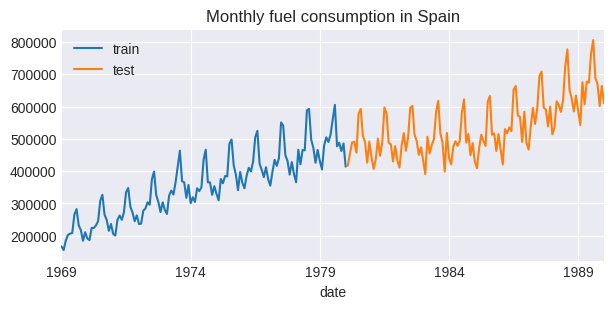

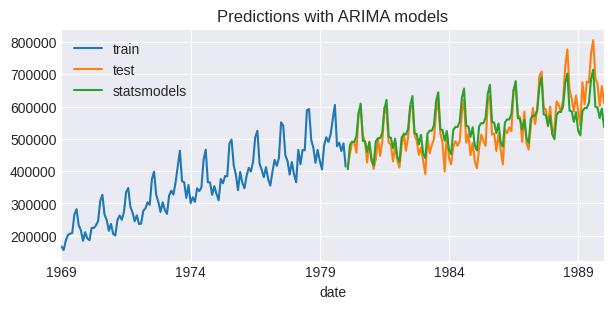

In [ ]:

end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()


# model = ARIMA(data_train, order=(1, 1, 1)).fit()
# predictions = model.forecast(steps=len(data_test))
model = SARIMAX (data_train, order = (0, 1, 1), seasonal_order = (1, 1, 1, 12), trend = 'n').fit()
predictions = model.forecast(steps=len(data_test))


# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='statsmodels')
ax.set_title('Predictions with ARIMA models')
ax.legend()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


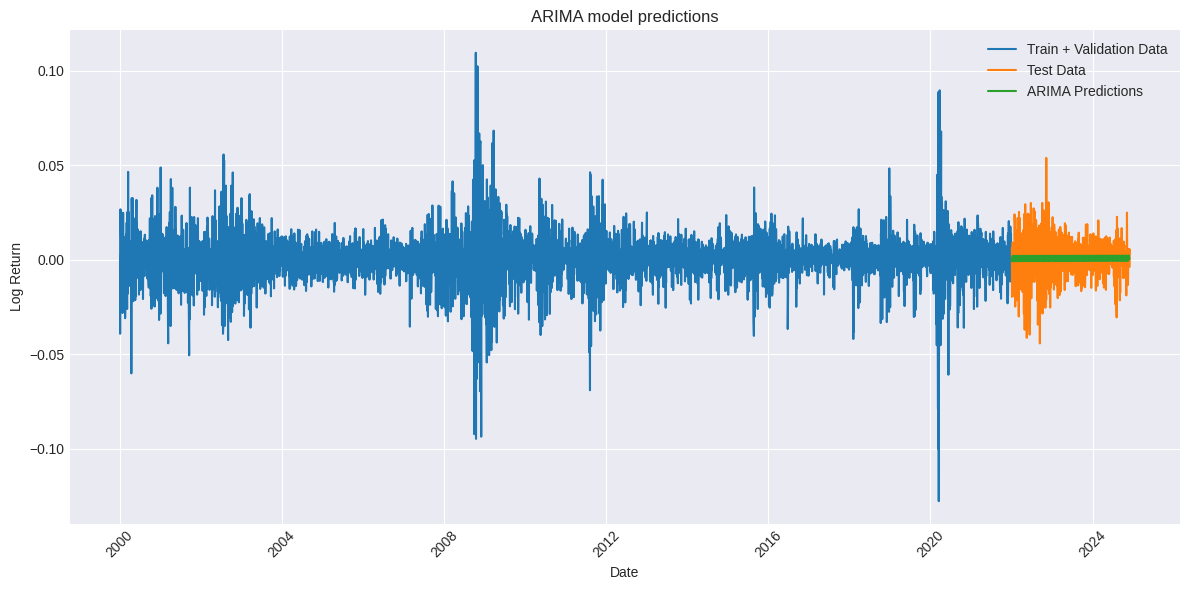

MSE: 0.0001233778023225485
RMSE 0.011107556091352791


0.011073557191113267

In [ ]:
# best_params = {'d': 0, 'p': 6, 'q': 6, 'trend': 'n'}
best_params = {'d': 0, 'p': 8, 'q': 13, 'trend': 'c', 'D': 0 , 'P': 1 , 'Q' : 13 , 'periods' : 12} #c assume a non zero mean
train_val_data = pd.concat([train_data, val_data])  #combine train and validation data
#model = SARIMAX(train_val_data, order=(best_params['p'], best_params['d'], best_params['q']), seasonal_order = (best_params['P'], best_params['D'], best_params['Q'], best_params['periods']), trend=best_params['trend']).fit()  #train model
model = SARIMAX(train_val_data, order = (1, 1, 1), seasonal_order = (0, 1, 1, 12)).fit()
forecast = model.forecast(steps=len(test_data)) ##predict


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=train_val_data.values, label="Train + Validation Data")
sns.lineplot(x=test_data.index, y=test_data.values, label="Test Data")
sns.lineplot(x=test_data.index, y=forecast, label="ARIMA Predictions")
plt.title('ARIMA model predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute MSE
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE', rmse)
0.011073557191113267

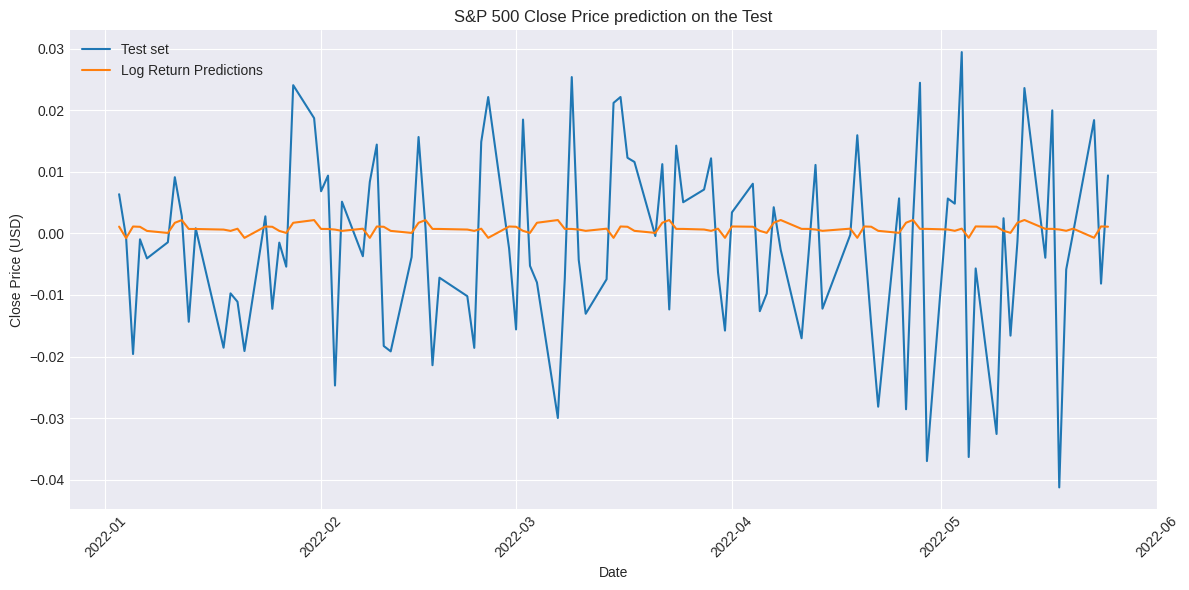

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data = test_data[:100], label="Test set")
sns.lineplot(data = forecast[:100], label="Log Return Predictions")
plt.title('S&P 500 Close Price prediction on the Test')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

##Hyperparameters tuning using Bayesian Optimization

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, train_data, val_data):
      self.conf_dict = configuration_params  # parameters to configure the Tuner
      self.njobs = njobs
      self.train_data = train_data
      self.val_data = val_data
      self.space = dict(p= range(1, 10), # Definition of the search space of the algorithm
                        d=[0],
                        q =range(1, 10),  #use of range to ensure integers
                        trend = ['n', 'c'],
                        Q = range(1, 10),
                        P = range(1, 10),
                        D = [0],
                        periods = [12]
                        )


  #This is the loss function that mango optimizes
  def arima_objetive_function(self, **params):
    params_evaluated = [] # list that will hold the parameters tested
    results = [] # thi will hold the MSE values for each parameter set.

    try:
      p,d,q = params['p'],params['d'], params['q']
      trend = params['trend']
      Q, P, D, periods = params['Q'], params['P'], params['D'], params['periods']
      model = SARIMAX(self.train_data, order=(p,d,q), trend = trend,  seasonal_order = (P, D, Q, periods)).fit() #train ARIMA model with the subset of hyperparameters
      print(f"SARIMA ({p,d,q}), ({P,D,Q}), {trend}")
      # model = ARIMA(train_data, order=(p,d,q), trend = trend).fit()
      predictions = model.forecast(steps=len(self.val_data)) #get forecast
      mse = mean_squared_error(self.val_data, predictions) #compute mse
      params_evaluated.append(params)
      results.append(mse)
    except:
      #print(f"Exception raised for {params}")
      #pass
      params_evaluated.append(params)
      results.append(1e5)  #if an error occurs the function appends a very large MSE (1e5) to results, which serves as a penalty for that parameter combination.
    return results


  def _objective2(self, params_batch): #to perform bayesian optimization in parallel
      global parameters
      results_batch = Parallel(self.njobs, backend="multiprocessing")(delayed(self.arima_objetive_function)(**params) for params in params_batch)
      rmse = [result for result in results_batch]
      return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


 # Parallel Bayesian optimization
config_params = {'num_iteration': 20, 'initial_random': 3}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, train_data=train_data, val_data=val_data)
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')

# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)

KeyboardInterrupt: 

In [ ]:
#define objective function
def sarima_objective_function (args_list):
  global train_data, test_data
  params_evaluated = [] # list that will hold the parameters tested
  results = [] # thi will hold the MSE values for each parameter set.

  for params in args_list:
      try:
          p,d,q = params['p'],params['d'], params['q']
          trend = params['trend']
          Q, P, D, periods = params['Q'], params['P'], params['D'], params['periods']
          model = SARIMAX(train_data, order=(p,d,q), trend = trend,  seasonal_order = (P, D, Q, periods)).fit() #train ARIMA model with the subset of hyperparameters
          print(f"SARIMA ({p,d,q}), ({P,D,Q}), {trend}")
          predictions = model.forecast(steps=len(test_data)) #get forecast
          mse = mean_squared_error(test_data, predictions) #compute mse
          params_evaluated.append(params)
          results.append(mse)
      except:
          #print(f"Exception raised for {params}")
          #pass
          params_evaluated.append(params)
          results.append(1e5)  #if an error occurs the function appends a very large MSE (1e5) to results, which serves as a penalty for that parameter combination.

      #print(params_evaluated, mse)
  return params_evaluated, results


#define the search space
param_space = dict(p= range(1, 10), # Definition of the search space of the algorithm
                   d=[0],
                   q =range(1, 10),  #use of range to ensure integers
                   trend = ['n', 'c'],
                   Q = range(1, 10),
                   P = range(1, 10),
                   D = [0],
                   periods = [12]
                  )


#run optimization
conf_Dict = {'num_iteration': 20 , 'initial_random' : 3}  #configuration dictionary , number of iteration
tuner = Tuner(param_space, sarima_objective_function, conf_Dict) # Initialize Tuner
results = tuner.minimize()  #Bayesian optimization to minimize the objective function
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

SARIMA ((4, 0, 1)), ((9, 0, 7)), n
SARIMA ((8, 0, 2)), ((5, 0, 4)), c
SARIMA ((7, 0, 5)), ((1, 0, 2)), c


  0%|          | 0/20 [00:00<?, ?it/s]

SARIMA ((6, 0, 3)), ((4, 0, 3)), n
SARIMA ((4, 0, 4)), ((4, 0, 6)), n
SARIMA ((8, 0, 5)), ((1, 0, 2)), c
SARIMA ((1, 0, 4)), ((6, 0, 9)), n
SARIMA ((5, 0, 3)), ((3, 0, 3)), n
SARIMA ((3, 0, 6)), ((8, 0, 3)), n
SARIMA ((7, 0, 8)), ((1, 0, 1)), c
SARIMA ((9, 0, 3)), ((7, 0, 4)), n
SARIMA ((9, 0, 1)), ((2, 0, 3)), c
SARIMA ((8, 0, 7)), ((1, 0, 3)), c
SARIMA ((7, 0, 6)), ((1, 0, 1)), c
SARIMA ((2, 0, 7)), ((4, 0, 5)), c
SARIMA ((8, 0, 4)), ((2, 0, 1)), c
SARIMA ((3, 0, 6)), ((4, 0, 8)), n
SARIMA ((5, 0, 8)), ((2, 0, 1)), c
SARIMA ((2, 0, 9)), ((3, 0, 3)), c
SARIMA ((6, 0, 9)), ((1, 0, 1)), n
SARIMA ((7, 0, 7)), ((3, 0, 1)), c
SARIMA ((3, 0, 4)), ((6, 0, 1)), n
SARIMA ((5, 0, 7)), ((1, 0, 1)), c
best parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 5, 'periods': 12, 'q': 7, 'trend': 'c'}
best loss: 0.00012257755170481068


##SARIMA prediction

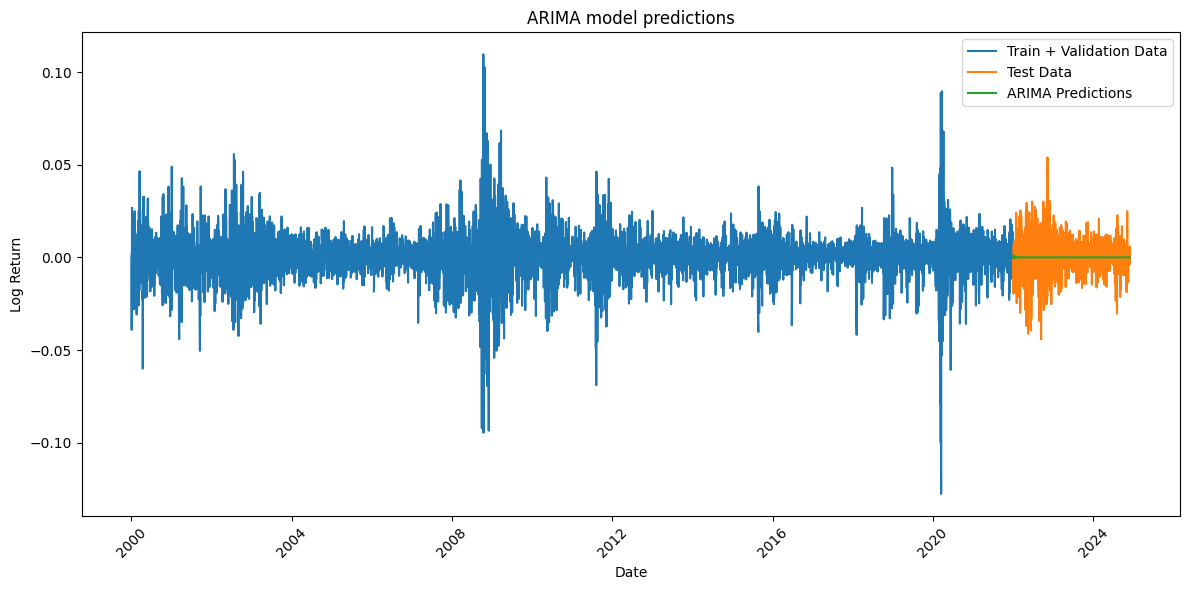

MSE: 0.00012251333619403337
RMSE 0.011068574262028211


In [ ]:
best_params = {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 5, 'periods': 12, 'q': 7, 'trend': 'c'}
train_val_data = pd.concat([train_data, val_data])  #combine train and validation data
model = SARIMAX(train_val_data, order = (best_params['p'], best_params['d'], best_params['q']), seasonal_order = (best_params['P'], best_params['D'], best_params['Q'], best_params['periods'])).fit()
#model = SARIMAX(train_val_data, order = (1, 1, 1), seasonal_order = (0, 1, 1, 6)).fit()
forecast = model.forecast(steps=len(test_data)) #predict
forecast.index = sp500_data.index[len(train_val_data):]


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=train_val_data.values, label="Train + Validation Data")
sns.lineplot(x=test_data.index, y=test_data.values, label="Test Data")
sns.lineplot(x=test_data.index, y=forecast, label="ARIMA Predictions")
plt.title('ARIMA model predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute MSE
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE', rmse)

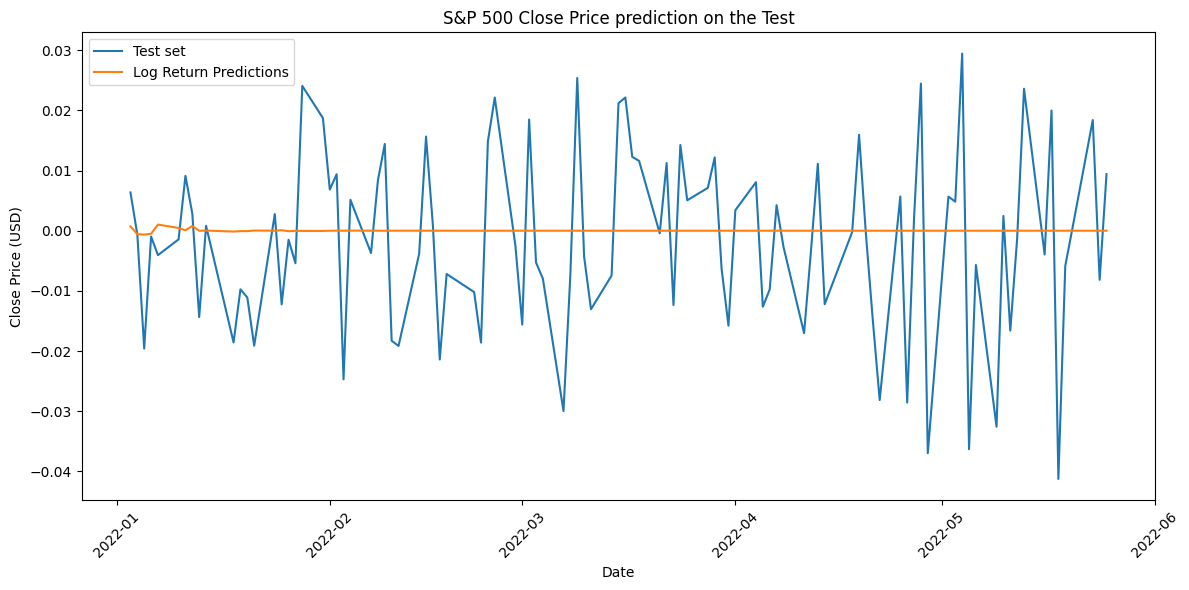

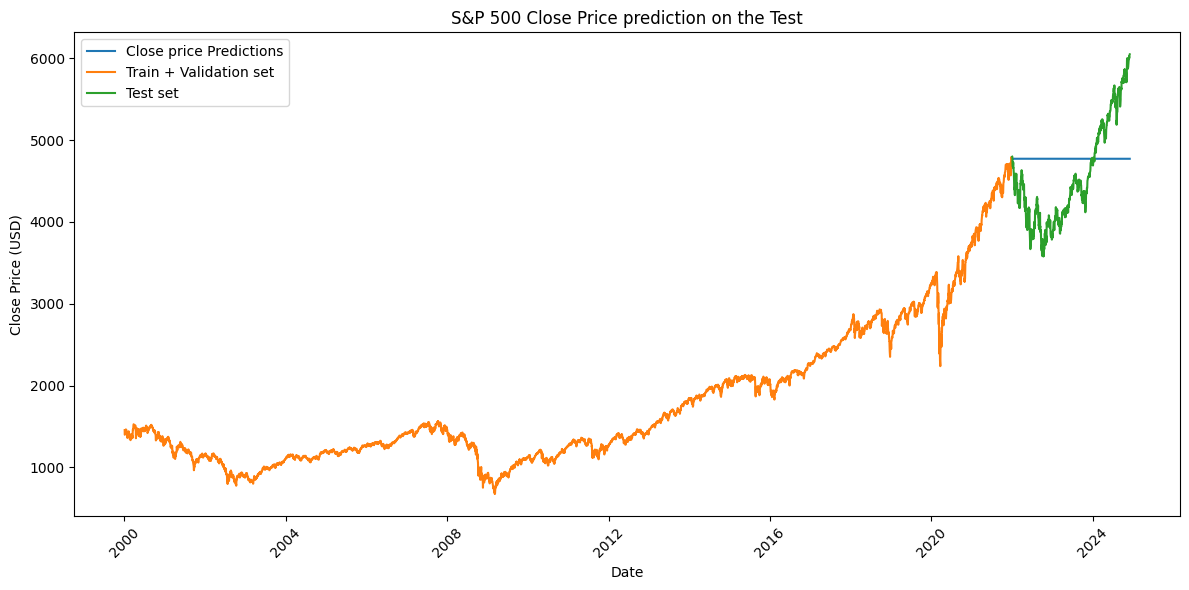

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data = test_data[:100], label="Test set")
sns.lineplot(data = forecast[:100], label="Log Return Predictions")
plt.title('S&P 500 Close Price prediction on the Test')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#cllose price predictions
forecast = pd.Series(forecast)
#forecast.index = sp500_data.index[len(train_val_data):]
lista = pd.concat([train_val_data, forecast])
pd.set_option('display.float_format', '{:.6f}'.format)
initial_price = sp500_data['Close']['^GSPC'].iloc[0]
predicted_close_price = initial_price * np.exp(lista.cumsum())
predicted_close_price

plt.figure(figsize=(12, 6))
sns.lineplot(data = predicted_close_price[len(train_val_data):], label="Close price Predictions")
sns.lineplot(data = sp500_data['Close']['^GSPC'][:len(train_val_data)], label="Train + Validation set")
sns.lineplot(x=sp500_data[len(train_val_data):].index, y=sp500_data['Close'][len(train_val_data):].squeeze(), label="Test set")
plt.title('S&P 500 Close Price prediction on the Test')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()